<a href="https://colab.research.google.com/github/Mafaz03/ReditScraper/blob/main/Scrapedit_dl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q praw
from datetime import datetime
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb
import praw
import pandas as pd
from tqdm import tqdm
import requests
from PIL import Image
from torchvision import transforms
from io import BytesIO
import numpy as np
import seaborn as sns

import torch
from torch.utils.data import Dataset, DataLoader
import requests
from PIL import Image
from io import BytesIO
import numpy as np
from tqdm import tqdm
import torchvision.transforms as transforms


In [2]:
pd.set_option('display.max_rows', None)

In [3]:
reddit = praw.Reddit(client_id = "uRyb_TFqvN7MbTU0cntBug",
            client_secret = "VAF_xUr-Q6h1JoZG-M8WE2RnLG8XlA",
            username = 'boyboyboi3',
            password = 'redditpassword03',
            redirect_uri = "http://localhost:8080",
            user_agent = "script by u/boyboyboi3",
            check_for_async=False)


In [4]:
class ResizeWithPadding(object):
  def __init__(self, size):
    self.size = size
  def __call__(self, img):
    w, h = img.size
    aspect_ratio = w / h
    if aspect_ratio > 1:
      new_w = self.size
      new_h = int(self.size / aspect_ratio)
    else:
      new_h = self.size
      new_w = int(self.size * aspect_ratio)
    resized_img = img.resize((new_w, new_h))
    new_img = Image.new("RGB", (self.size, self.size), color=(0, 0, 0))
    left = (self.size - new_w) // 2
    top = (self.size - new_h) // 2
    new_img.paste(resized_img, (left, top))
    return new_img

In [5]:
class ScrapeditDataset(Dataset):
  def __init__(self, subreddit: list, limit=10, sortby='year', show_safe=None, max_size=500, transform=None):
    if transform: self.transform = transform
    else: self.transform = transforms.ToTensor()
    self.subreddit = subreddit
    self.max_size = max_size
    self.results = {}
    for r in self.subreddit:
      sub = reddit.subreddit(r)
      sub_itter = sub.top(sortby, limit=limit)
      self.result = []
      for submission in tqdm(sub_itter):
        self.d = {}
        try:
            self.d['image'] = submission.preview["images"][0]["source"]["url"]
        except:
            self.d['image'] = None
        self.d['domain'] = submission.domain
        self.result.append(self.d)
      self.results[r] = self.result

    self.colated_ds = []
    for r in self.subreddit:
      for image in self.results[r]:
        try:
          response = requests.get(image['image'])
          self.colated_ds.append([image['image'], r])
        except: pass

  def __len__(self):
    return len(self.colated_ds)

  def __getitem__(self, idx):

    link, y = self.colated_ds[idx]
    response = requests.get(link)
    image = Image.open(BytesIO(response.content))
    image.thumbnail((self.max_size, self.max_size), Image.LANCZOS)
    if image.mode != 'RGB': image = image.convert('RGB')
    img_tensor = self.transform(image)
    if img_tensor.shape[0] == 3: img_tensor = img_tensor.permute(1, 2, 0)
    np_image = np.array(img_tensor)
    return {'image': np_image, 'y': y}


In [ ]:
size = 100
transform_resize=transforms.Compose([
                              ResizeWithPadding(size=size),
                              transforms.Resize((size,size)),
                              transforms.ToTensor()
                              ])

subreddits = ['food', 'art']
dataset = ScrapeditDataset(subreddit=subreddits, limit = 500, transform = transform_resize)
dataloader = DataLoader(dataset, batch_size = 100, shuffle=True)

<ipython-input-5-95b71bcb7d75>:10: DeprecationWarning: Positional arguments for 'BaseListingMixin.top' will no longer be supported in PRAW 8.
Call this function with 'time_filter' as a keyword argument.
  sub_itter = sub.top(sortby, limit=limit)
461it [02:02,  1.42it/s]

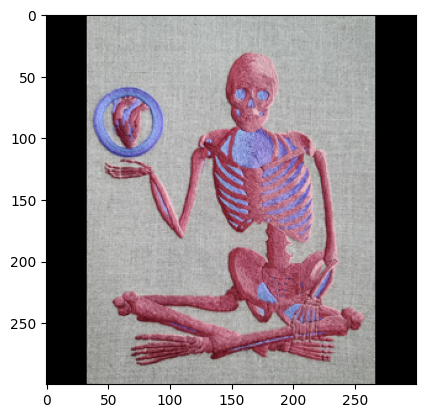

In [31]:
plt.imshow(next(iter(dataloader))['image'][2])

In [48]:
import torch.nn.functional as F
from torch import nn
flatten = nn.Flatten()

class MyModel(nn.Module):
  def __init__(self):
    super(MyModel, self).__init__()
    self.features = nn.Sequential(
        nn.Conv2d(300, 8, kernel_size=3, stride=2, padding=1),
        nn.ReLU(),
        nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1),
        nn.ReLU(),
        nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
        nn.ReLU(),
        nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
        nn.ReLU(),
        nn.Conv2d(64, 2, kernel_size=3, stride=2, padding=1)
    )

    self.global_pool = nn.AdaptiveAvgPool2d(1)

  def forward(self, x):
      x = self.features(x)
      x = self.global_pool(x)
      x = flatten(x)  # Flatten the feature maps
      # Get the index of the highest probability for each image
      return x
      _, predicted_classes = torch.max(x, 1)
      return predicted_classes

In [49]:
model = MyModel()

In [50]:
r_map = {'food': 0, 'art': 1}

In [51]:
dataloader

In [56]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Define number of epochs
num_epochs = 5
accs = []
losses = []

# Training loop
for epoch in range(num_epochs):
  running_loss = 0.0
  running_accuracy = 0.0
  for i, data in enumerate(dataloader):
    # Get the inputs; data is a list of [inputs, labels]
    # inputs, labels = data
    inputs = data['image']
    y = data['y']

    # Zero the parameter gradients
    optimizer.zero_grad()

    # Forward + backward + optimize
    y_pred = model(inputs)
    y = torch.asarray([r_map[i] for i in y])

    accuracy = (sum(y_pred.argmax(1) ==  y)/len(y)).item()
    running_accuracy += accuracy
    accs.append(accuracy)

    loss = criterion(y_pred, y)
    losses.append(loss)
    loss.backward()
    optimizer.step()

    # Print statistics
    running_loss += loss.item()
  epoch_loss = running_loss / len(dataloader)
  epoch_accuracy = running_accuracy / len(dataloader)
  print(f'Epoch {epoch + 1}, Loss: {epoch_loss:.3f}, Accuracy: {epoch_accuracy*100:.3f}')



Epoch 1, Mini-batch 4, Loss: 0.920, Accuracy: 67.708
Epoch 2, Mini-batch 4, Loss: 0.697, Accuracy: 51.083
Epoch 3, Mini-batch 4, Loss: 0.686, Accuracy: 53.500
Epoch 4, Mini-batch 4, Loss: 0.683, Accuracy: 56.500
Epoch 5, Mini-batch 4, Loss: 0.680, Accuracy: 58.667


In [63]:
accs

[0.7200000286102295,
 0.6399999856948853,
 0.6399999856948853,
 0.7083333134651184,
 0.5199999809265137,
 0.41999998688697815,
 0.5199999809265137,
 0.5833333134651184,
 0.5799999833106995,
 0.5400000214576721,
 0.5199999809265137,
 0.5,
 0.6000000238418579,
 0.6000000238418579,
 0.5600000023841858,
 0.5,
 0.5,
 0.6000000238418579,
 0.5799999833106995,
 0.6666666865348816]

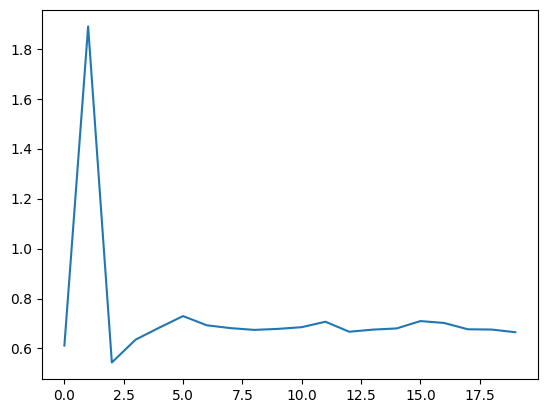

In [61]:
plt.plot([i.item() for i in losses])

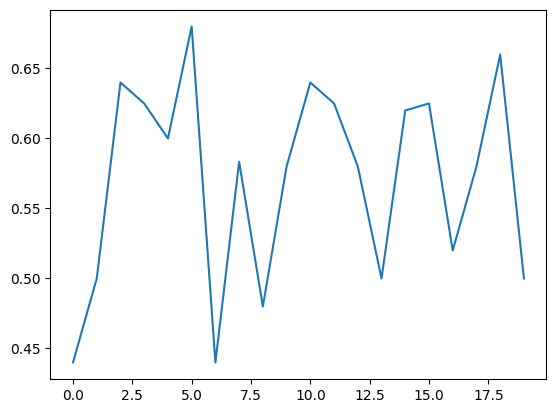

In [64]:
plt.plot(acc)